## Importieren aller benötigten Bibliotheken

In [1]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
from openml.datasets import get_dataset
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import TweedieRegressor
from sklearn.model_selection import train_test_split
from datetime import datetime
import pickle

## Laden des Datensatzes freMTPL2freq

In [2]:
dataset = get_dataset(41214)

In [4]:
data, target, item1, item2 = dataset.get_data(target=dataset.default_target_attribute)

## Explorative Datenanalyse

In [5]:
# Erster Check des Datensatzes
data.tail(5)

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
678008,6114326.00,0,0.00,E,4,0,54,50,B12,Regular,3317.00,R93
678009,6114327.00,0,0.00,E,4,0,41,95,B12,Regular,9850.00,R11
678010,6114328.00,0,0.00,D,6,2,45,50,B12,Diesel,1323.00,R82
678011,6114329.00,0,0.00,B,4,0,60,50,B12,Regular,95.00,R26
678012,6114330.00,0,0.00,B,7,6,29,54,B12,Diesel,65.00,R72


In [7]:
# Übersicht über die Datentypen und Nullwerte
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   IDpol       678013 non-null  float64 
 1   ClaimNb     678013 non-null  uint8   
 2   Exposure    678013 non-null  float64 
 3   Area        678013 non-null  category
 4   VehPower    678013 non-null  uint8   
 5   VehAge      678013 non-null  uint8   
 6   DrivAge     678013 non-null  uint8   
 7   BonusMalus  678013 non-null  uint8   
 8   VehBrand    678013 non-null  category
 9   VehGas      678013 non-null  object  
 10  Density     678013 non-null  float64 
 11  Region      678013 non-null  category
dtypes: category(3), float64(3), object(1), uint8(5)
memory usage: 25.9+ MB


In [8]:
# Übersicht über die statistischen Eigenschaften der nummerischen Spalten des Datensatzes
data.describe()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00
mean,2621856.92,0.05,0.53,6.45,7.04,45.50,59.76,1792.42
std,1641782.75,0.24,0.36,2.05,5.67,14.14,15.64,3958.65
min,1.00,0.00,0.00,4.00,0.00,18.00,50.00,1.00
25%,1157951.00,0.00,0.18,5.00,2.00,34.00,50.00,92.00
50%,2272152.00,0.00,0.49,6.00,6.00,44.00,50.00,393.00
75%,4046274.00,0.00,0.99,7.00,11.00,55.00,64.00,1658.00
max,6114330.00,16.00,2.01,15.00,100.00,100.00,230.00,27000.00


In [10]:
# Analyse der kategorialen Spalten des Datensatzes und Ausgabe der verschiedenen Kategorien je Spalte
for col in data.select_dtypes(include=['category', 'object']):
    print(col + ': ' + ', '.join(data[col].unique().astype(str)))

Area: D, B, E, C, F, A
VehBrand: B12, B6, B3, B2, B5, B10, B14, B13, B4, B1, B11
VehGas: Regular, Diesel
Region: R82, R22, R72, R31, R91, R52, R93, R11, R24, R94, R83, R54, R26, R53, R73, R42, R25, R21, R41, R43, R74, R23


In [11]:
# Auflistung der Namen des Datensatzes
data.columns

Index(['IDpol', 'ClaimNb', 'Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region'],
      dtype='object')

In [12]:
# Auflistung der Value Counts für die nummerischen Spalten 
# => die Anzahl an Schäden im versicherungszeitraum beträgt sehr oft null
# Außerdem sind verschiedene Werte ungleich verteilt, wie Area, VehAge oder DrivAge
for col in data[['ClaimNb', 'Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region']].columns:
    print(col)
    print(data[col].value_counts())

ClaimNb
0     643953
1      32178
2       1784
3         82
4          7
11         3
5          2
6          1
8          1
9          1
16         1
Name: ClaimNb, dtype: int64
Exposure
1.00    168125
0.08     44670
0.07     12969
0.24     12950
0.50     12497
         ...  
1.63         1
1.92         1
1.70         1
1.67         1
1.71         1
Name: Exposure, Length: 181, dtype: int64
Area
C    191880
D    151596
E    137167
A    103957
B     75459
F     17954
Name: Area, dtype: int64
VehPower
6     148976
7     145401
5     124821
4     115349
8      46956
10     31354
9      30085
11     18352
12      8214
13      3229
15      2926
14      2350
Name: VehPower, dtype: int64
VehAge
1     71284
2     59124
0     57739
3     50261
4     43492
      ...  
55        1
82        1
84        1
85        1
63        1
Name: VehAge, Length: 78, dtype: int64
DrivAge
36     17530
38     17346
39     17320
37     17295
52     17195
       ...  
95        24
96        15
97        10
98    

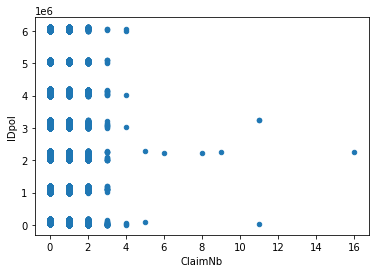

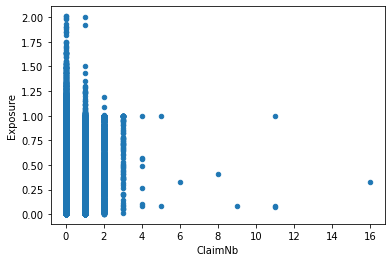

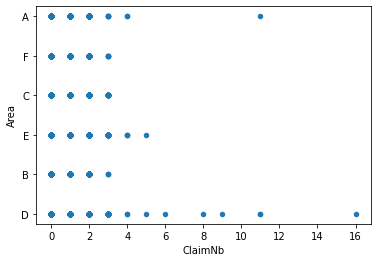

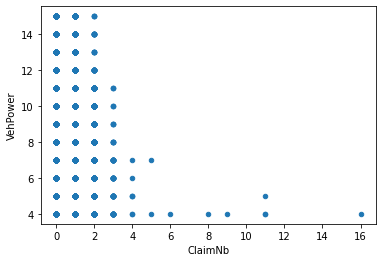

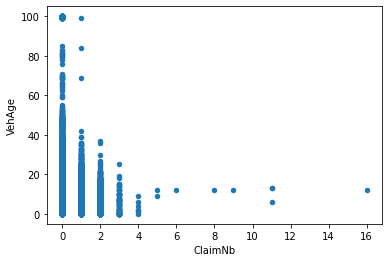

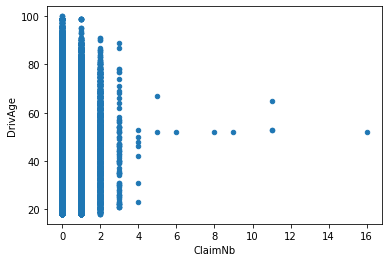

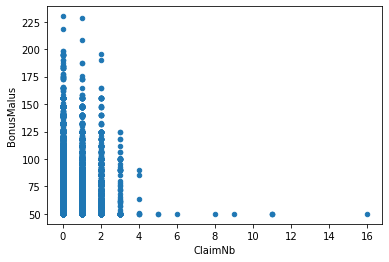

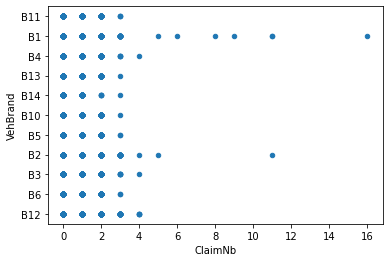

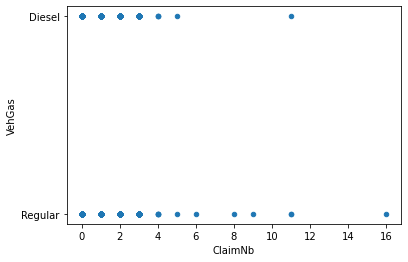

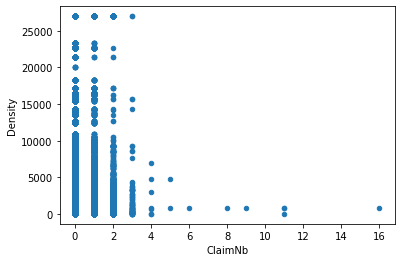

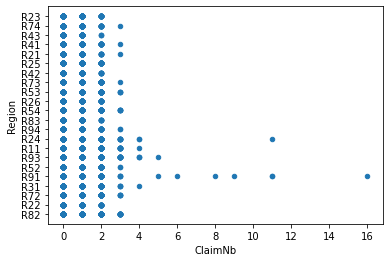

In [13]:
# Analyse des Zusammenhangs zwischen allen anderen Spalten des Datensatzes und des ClaimAmounts
x_col = 'ClaimNb'

columns = data.columns.tolist()

# Entferne die Spalte 'ClaimNb' von der Liste der Spalten
columns.remove(x_col)

# Loop über alle anderen Spalten und Kreieren von Scatter Plots
for col in columns:
    data.plot.scatter(x=x_col, y=col)
    
# Beispielsweise weisen ClaimNb und DrivAge im Bereich 50 Jahre eine Auffälligkeit auf
# Auch VehBrand B1 und BonusMalus im Bereich 50 sowie die Region R91

In [14]:
# One Hot Encoding der kategorialen Spalten, um nummerische Werte zu erhalten.
cat_cols = data.select_dtypes(include=['category', 'object']).columns.tolist()

for col in cat_cols:
    data = pd.concat([data, pd.get_dummies(data[col], prefix=col)], axis=1)

# Entfernen der ursprünglichen kategorialen Spalte
data = data.drop(cat_cols, axis=1)

In [15]:
# Übersicht über den entstandenen Datensatz
data.head(10)

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,Area_A,Area_B,...,Region_R53,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94
0,1.00,1,0.10,5,0,55,50,1217.00,0,0,...,0,0,0,0,0,1,0,0,0,0
1,3.00,1,0.77,5,0,55,50,1217.00,0,0,...,0,0,0,0,0,1,0,0,0,0
2,5.00,1,0.75,6,2,52,50,54.00,0,1,...,0,0,0,0,0,0,0,0,0,0
3,10.00,1,0.09,7,0,46,50,76.00,0,1,...,0,0,1,0,0,0,0,0,0,0
4,11.00,1,0.84,7,0,46,50,76.00,0,1,...,0,0,1,0,0,0,0,0,0,0
5,13.00,1,0.52,6,2,38,50,3003.00,0,0,...,0,0,0,0,0,0,0,0,0,0
6,15.00,1,0.45,6,2,38,50,3003.00,0,0,...,0,0,0,0,0,0,0,0,0,0
7,17.00,1,0.27,7,0,33,68,137.00,0,0,...,0,0,0,0,0,0,0,1,0,0
8,18.00,1,0.71,7,0,33,68,137.00,0,0,...,0,0,0,0,0,0,0,1,0,0
9,21.00,1,0.15,7,0,41,50,60.00,0,1,...,0,0,0,0,0,0,0,0,0,0


## Laden des zweiten Datensatzes freMTPL2sev

In [18]:
freMTPL2sev = get_dataset(41215)

In [19]:
data_y, target, item1, item2 = freMTPL2sev.get_data(target=freMTPL2sev.default_target_attribute)

attribute_names = freMTPL2sev.features

if target is not None:
    df = pd.concat([pd.DataFrame(data_y, columns=attribute_names), pd.DataFrame(target, columns=[freMTPL2sev.default_target_attribute])], axis=1)
else:
    df = pd.DataFrame(data_y, columns=attribute_names)

In [20]:
# Beschreibung der Spalte ClaimAmount des zweiten Datensatzes
data_y['ClaimAmount'].describe()

count     26639.00
mean       2278.54
std       29297.48
min           1.00
25%         686.81
50%        1172.00
75%        1228.08
max     4075400.56
Name: ClaimAmount, dtype: float64

In [21]:
# Ausgabe der zehn höchsten Werte der Spalte ClaimAmount
data_y['ClaimAmount'].nlargest(10)

9756    4075400.56
15768   1403057.40
11637   1301172.60
17992    774411.50
2869     390742.27
3307     369131.88
9999     307096.42
5521     301635.49
18627    287423.00
18295    281897.49
Name: ClaimAmount, dtype: float64

In [22]:
# Ausgabe aller Spalten für den maximalen Betrag des ClaimAmounts
data_y[data_y['ClaimAmount']==4075400.56]

,IDpol,ClaimAmount
9756,1120377.00,4075400.56


Text(0.5, 1.0, 'Histogram with Logarithmic Y-axis')

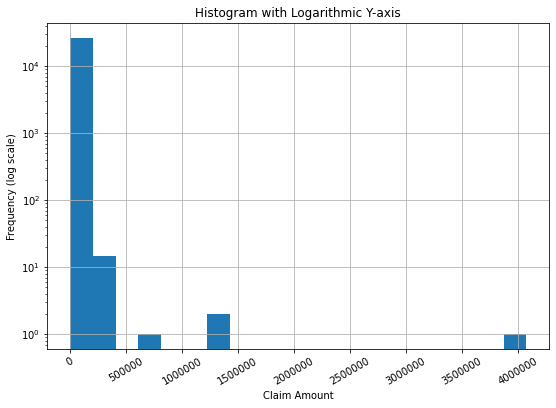

In [23]:
# Visualisierung der Verteilung der ClaimAmounts im gesamten Datensatz als Histogramm mit logarithmischer y-Achse

fig, ax = plt.subplots()
data_y['ClaimAmount'].hist(ax=ax, bins=20, log=True, figsize=(9,6))

# Rotation der Beschriftung der x-Achse um 30 Grad
plt.xticks(rotation=30)

# Formatteirung der x-Achsen-Labels
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)

# Setzen der Labels
ax.set_xlabel('Claim Amount')
ax.set_ylabel('Frequency (log scale)')
ax.set_title('Histogram with Logarithmic Y-axis')


In [ ]:
# => Die meisten ClaimAmounts liegen im niedrigeren Bereich
# => einzelne Ausreißer sind bei Werten von über 500k zu finden.

In [24]:
# Asugabe der Anzahl an Zeilen im Datensatz
len(data_y)

26639

In [25]:
# Ausgabe der Anzahl an IDs im Datensatz => für verschiedene IDs sind mehrere Schadenaufwände zu finden.
data_y.IDpol.nunique()

24950

In [26]:
# Daher Berechnung des durchschnittlichen Claim Amounts pro ID.
mean_claim_amount = data_y.groupby('IDpol')['ClaimAmount'].mean()

In [86]:
mean_claim_amount.describe()

count     24950.00
mean       2221.84
std       28989.12
min           1.00
25%         711.22
50%        1172.00
75%        1228.08
max     4075400.56
Name: ClaimAmount, dtype: float64

In [27]:
mean_claim_amount.head()

IDpol
139.00    303.00
190.00   1981.84
414.00   1456.55
424.00   5417.00
463.00   3986.67
Name: ClaimAmount, dtype: float64

In [30]:
# Kreieren eines Pandas Dataframes aus der Series mean_claim_amount
df_mean_claim_amount = mean_claim_amount.to_frame()

In [36]:
# Resetten des Index, um Dataframes zu mergen
df_mean_claim_amount.reset_index(inplace=True)

In [37]:
df_mean_claim_amount

,IDpol,ClaimAmount
0,139.00,303.00
1,190.00,1981.84
2,414.00,1456.55
3,424.00,5417.00
4,463.00,3986.67
...,...,...
24945,6113521.00,1324.40
24946,6113793.00,1769.88
24947,6113817.00,1288.28
24948,6113834.00,6115.20


In [38]:
# Mergen bzw. Left Join der Datensätze auf IDpol-Spalte
merged_df = pd.merge(data, df_mean_claim_amount, on='IDpol', how='left')

In [39]:
merged_df

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,Area_A,Area_B,...,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94,ClaimAmount
0,1.00,1,0.10,5,0,55,50,1217.00,0,0,...,0,0,0,0,1,0,0,0,0,NaN
1,3.00,1,0.77,5,0,55,50,1217.00,0,0,...,0,0,0,0,1,0,0,0,0,NaN
2,5.00,1,0.75,6,2,52,50,54.00,0,1,...,0,0,0,0,0,0,0,0,0,NaN
3,10.00,1,0.09,7,0,46,50,76.00,0,1,...,0,1,0,0,0,0,0,0,0,NaN
4,11.00,1,0.84,7,0,46,50,76.00,0,1,...,0,1,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326.00,0,0.00,4,0,54,50,3317.00,0,0,...,0,0,0,0,0,0,0,1,0,NaN
678009,6114327.00,0,0.00,4,0,41,95,9850.00,0,0,...,0,0,0,0,0,0,0,0,0,NaN
678010,6114328.00,0,0.00,6,2,45,50,1323.00,0,0,...,0,0,0,0,1,0,0,0,0,NaN
678011,6114329.00,0,0.00,4,0,60,50,95.00,0,1,...,0,0,0,0,0,0,0,0,0,NaN


In [40]:
# Umbennung des gemergten Datensatzes in df
df = merged_df

In [41]:
# Auffüllen der NaN-Werte der Saplte Claim Amount mit Nullen
df['ClaimAmount'] = df['ClaimAmount'].fillna(0)

In [42]:
df[df['ClaimAmount']!=0]

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,Area_A,Area_B,...,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94,ClaimAmount
66,139.00,1,0.75,7,1,61,50,27000.00,0,0,...,0,0,0,0,0,0,0,0,0,303.00
93,190.00,1,0.14,12,5,50,60,56.00,0,1,...,0,0,0,0,0,0,0,0,0,1981.84
199,414.00,1,0.14,4,0,36,85,4792.00,0,0,...,0,0,0,0,0,0,0,0,0,1456.55
205,424.00,2,0.62,10,0,51,100,27000.00,0,0,...,0,0,0,0,0,0,0,0,0,5417.00
223,463.00,1,0.31,5,0,45,50,12.00,1,0,...,0,0,1,0,0,0,0,0,0,3986.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677203,6113521.00,1,0.18,4,1,26,60,311.00,0,0,...,0,0,0,0,1,0,0,0,0,1324.40
677475,6113793.00,1,0.14,7,2,51,50,178.00,0,0,...,0,1,0,0,0,0,0,0,0,1769.88
677499,6113817.00,1,0.17,4,0,35,51,1719.00,0,0,...,0,0,0,0,1,0,0,0,0,1288.28
677516,6113834.00,2,0.17,15,3,36,50,181.00,0,0,...,1,0,0,0,0,0,0,0,0,6115.20


Text(0.5, 1.0, 'Histogram with Logarithmic Y-axis')

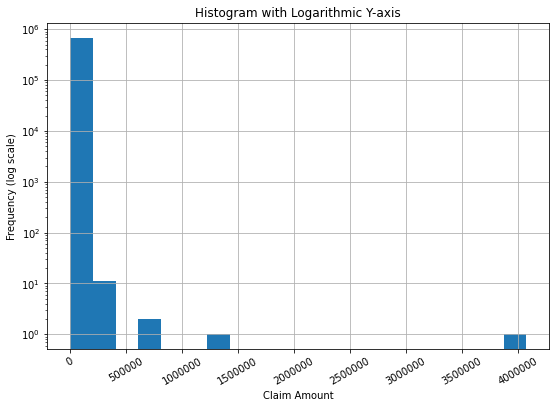

In [43]:
# Darstellung der ClaimAmounts als Histogramm mit logarithmischer y-Achse
fig, ax = plt.subplots()
df['ClaimAmount'].hist(ax=ax, bins=20, log=True, figsize=(9,6))

plt.xticks(rotation=30)

formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)

ax.set_xlabel('Claim Amount')
ax.set_ylabel('Frequency (log scale)')
ax.set_title('Histogram with Logarithmic Y-axis')

In [44]:
# Ausgabe aller Spalten des Dataframes df
df.columns

Index(['IDpol', 'ClaimNb', 'Exposure', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'Density', 'Area_A', 'Area_B', 'Area_C', 'Area_D',
       'Area_E', 'Area_F', 'VehBrand_B1', 'VehBrand_B10', 'VehBrand_B11',
       'VehBrand_B12', 'VehBrand_B13', 'VehBrand_B14', 'VehBrand_B2',
       'VehBrand_B3', 'VehBrand_B4', 'VehBrand_B5', 'VehBrand_B6',
       'VehGas_Diesel', 'VehGas_Regular', 'Region_R11', 'Region_R21',
       'Region_R22', 'Region_R23', 'Region_R24', 'Region_R25', 'Region_R26',
       'Region_R31', 'Region_R41', 'Region_R42', 'Region_R43', 'Region_R52',
       'Region_R53', 'Region_R54', 'Region_R72', 'Region_R73', 'Region_R74',
       'Region_R82', 'Region_R83', 'Region_R91', 'Region_R93', 'Region_R94',
       'ClaimAmount'],
      dtype='object')

In [45]:
# Darstellung ausgewählter Spalten als Korrelationsmatrix
df_corr = df[['VehBrand_B1', 'VehBrand_B10', 'VehBrand_B11',
       'VehBrand_B12', 'VehBrand_B13', 'VehBrand_B14', 'VehBrand_B2',
       'VehBrand_B3', 'VehBrand_B4', 'VehBrand_B5', 'VehBrand_B6', 
       'ClaimAmount']]

In [46]:
corr_matrix = df_corr.corr()

<AxesSubplot:>

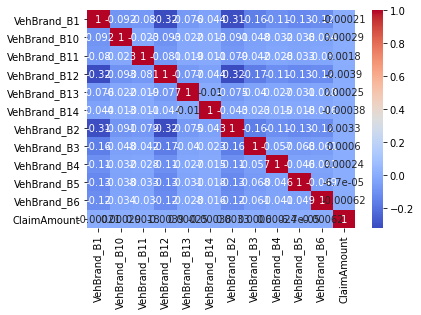

In [47]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

In [48]:
# Unübersichtliche Darstellung, daher anderer Ansatz:
# Ausgabe aller Spalten, die zueinander eine besonders hohe Korrelation aufweisen

In [49]:
df_corr = df[['ClaimNb', 'Exposure', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'Density', 'Area_A', 'Area_B', 'Area_C', 'Area_D',
       'Area_E', 'Area_F', 'VehBrand_B1', 'VehBrand_B10', 'VehBrand_B11',
       'VehBrand_B12', 'VehBrand_B13', 'VehBrand_B14', 'VehBrand_B2',
       'VehBrand_B3', 'VehBrand_B4', 'VehBrand_B5', 'VehBrand_B6',
       'VehGas_Diesel', 'VehGas_Regular', 'Region_R11', 'Region_R21',
       'Region_R22', 'Region_R23', 'Region_R24', 'Region_R25', 'Region_R26',
       'Region_R31', 'Region_R41', 'Region_R42', 'Region_R43', 'Region_R52',
       'Region_R53', 'Region_R54', 'Region_R72', 'Region_R73', 'Region_R74',
       'Region_R82', 'Region_R83', 'Region_R91', 'Region_R93', 'Region_R94',
       'ClaimAmount']]

In [50]:
corr_matrix = df_corr.corr()

In [51]:
high_corr = (corr_matrix.abs() > 0.7).sum() > 1
print(high_corr)

ClaimNb           False
Exposure          False
VehPower          False
VehAge            False
DrivAge           False
BonusMalus        False
Density            True
Area_A            False
Area_B            False
Area_C            False
Area_D            False
Area_E            False
Area_F             True
VehBrand_B1       False
VehBrand_B10      False
VehBrand_B11      False
VehBrand_B12      False
VehBrand_B13      False
VehBrand_B14      False
VehBrand_B2       False
VehBrand_B3       False
VehBrand_B4       False
VehBrand_B5       False
VehBrand_B6       False
VehGas_Diesel      True
VehGas_Regular     True
Region_R11        False
Region_R21        False
Region_R22        False
Region_R23        False
Region_R24        False
Region_R25        False
Region_R26        False
Region_R31        False
Region_R41        False
Region_R42        False
Region_R43        False
Region_R52        False
Region_R53        False
Region_R54        False
Region_R72        False
Region_R73      

In [52]:
# Zumindest eine der Spalten wird in der anschließenden Analyse ausgeschlossen wegen Gefahr von Multikollinearität.
high_corr_pairs = corr_matrix.loc[high_corr, high_corr]
print(high_corr_pairs)

                Density  Area_F  VehGas_Diesel  VehGas_Regular
Density            1.00    0.84          -0.10            0.10
Area_F             0.84    1.00          -0.06            0.06
VehGas_Diesel     -0.10   -0.06           1.00           -1.00
VehGas_Regular     0.10    0.06          -1.00            1.00


## Feature Engineering

In [53]:
# Berechnung der abhängigen Variable: ClaimAmount pro Jahr
df['ClaimAmount_year'] = df['ClaimAmount'] / df['Exposure']

In [54]:
# Berechnung der unabhängigen Variable Frequency => Anzahl Schäden pro Jahr.
df['Frequency'] = df['ClaimNb'] / df['Exposure']

In [55]:
df.columns

Index(['IDpol', 'ClaimNb', 'Exposure', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'Density', 'Area_A', 'Area_B', 'Area_C', 'Area_D',
       'Area_E', 'Area_F', 'VehBrand_B1', 'VehBrand_B10', 'VehBrand_B11',
       'VehBrand_B12', 'VehBrand_B13', 'VehBrand_B14', 'VehBrand_B2',
       'VehBrand_B3', 'VehBrand_B4', 'VehBrand_B5', 'VehBrand_B6',
       'VehGas_Diesel', 'VehGas_Regular', 'Region_R11', 'Region_R21',
       'Region_R22', 'Region_R23', 'Region_R24', 'Region_R25', 'Region_R26',
       'Region_R31', 'Region_R41', 'Region_R42', 'Region_R43', 'Region_R52',
       'Region_R53', 'Region_R54', 'Region_R72', 'Region_R73', 'Region_R74',
       'Region_R82', 'Region_R83', 'Region_R91', 'Region_R93', 'Region_R94',
       'ClaimAmount', 'ClaimAmount_year', 'Frequency'],
      dtype='object')

In [56]:
# Entfernen verschiedener Spalten aus dem Datensatz: ClaimNb, ClaimAmount
df = df[['IDpol', 'Frequency', 'Exposure', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'Density', 'Area_A', 'Area_B', 'Area_C', 'Area_D',
       'Area_E', 'Area_F', 'VehBrand_B1', 'VehBrand_B10', 'VehBrand_B11',
       'VehBrand_B12', 'VehBrand_B13', 'VehBrand_B14', 'VehBrand_B2',
       'VehBrand_B3', 'VehBrand_B4', 'VehBrand_B5', 'VehBrand_B6',
       'VehGas_Diesel', 'VehGas_Regular', 'Region_R11', 'Region_R21',
       'Region_R22', 'Region_R23', 'Region_R24', 'Region_R25', 'Region_R26',
       'Region_R31', 'Region_R41', 'Region_R42', 'Region_R43', 'Region_R52',
       'Region_R53', 'Region_R54', 'Region_R72', 'Region_R73', 'Region_R74',
       'Region_R82', 'Region_R83', 'Region_R91', 'Region_R93', 'Region_R94', 
        'ClaimAmount_year']]

In [63]:
# Entfernen einer Spalte der kategorialen Variablen, um Multikollinearität zu vermeiden
df.columns

Index(['IDpol', 'Frequency', 'Exposure', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'Density', 'Area_A', 'Area_B', 'Area_C', 'Area_D',
       'Area_E', 'Area_F', 'VehBrand_B1', 'VehBrand_B10', 'VehBrand_B11',
       'VehBrand_B12', 'VehBrand_B13', 'VehBrand_B14', 'VehBrand_B2',
       'VehBrand_B3', 'VehBrand_B4', 'VehBrand_B5', 'VehBrand_B6',
       'VehGas_Diesel', 'VehGas_Regular', 'Region_R11', 'Region_R21',
       'Region_R22', 'Region_R23', 'Region_R24', 'Region_R25', 'Region_R26',
       'Region_R31', 'Region_R41', 'Region_R42', 'Region_R43', 'Region_R52',
       'Region_R53', 'Region_R54', 'Region_R72', 'Region_R73', 'Region_R74',
       'Region_R82', 'Region_R83', 'Region_R91', 'Region_R93', 'Region_R94',
       'ClaimAmount_year'],
      dtype='object')

In [64]:
df = df[['IDpol', 'Frequency', 'Exposure', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'Density', 'Area_A', 'Area_B', 'Area_C', 'Area_D',
       'Area_E', 'VehBrand_B10', 'VehBrand_B11', 'VehBrand_B12',
       'VehBrand_B13', 'VehBrand_B14', 'VehBrand_B2', 'VehBrand_B3',
       'VehBrand_B4', 'VehBrand_B5', 'VehBrand_B6', 'VehGas_Regular',
       'Region_R21', 'Region_R22', 'Region_R23', 'Region_R24', 'Region_R25',
       'Region_R26', 'Region_R31', 'Region_R41', 'Region_R42', 'Region_R43',
       'Region_R52', 'Region_R53', 'Region_R54', 'Region_R72', 'Region_R73',
       'Region_R74', 'Region_R82', 'Region_R83', 'Region_R91', 'Region_R93',
       'Region_R94', 'ClaimAmount_year']]

In [65]:
# Setzen eines Indexes
df.set_index('IDpol', inplace=True)

In [66]:
df.head()

,Frequency,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,Area_A,Area_B,Area_C,...,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94,ClaimAmount_year
IDpol,,,,,,,,,,,,,,,,,,,,,
1.00,10.00,0.10,5,0,55,50,1217.00,0,0,0,...,0,0,0,0,1,0,0,0,0,0.00
3.00,1.30,0.77,5,0,55,50,1217.00,0,0,0,...,0,0,0,0,1,0,0,0,0,0.00
5.00,1.33,0.75,6,2,52,50,54.00,0,1,0,...,0,0,0,0,0,0,0,0,0,0.00
10.00,11.11,0.09,7,0,46,50,76.00,0,1,0,...,0,1,0,0,0,0,0,0,0,0.00
11.00,1.19,0.84,7,0,46,50,76.00,0,1,0,...,0,1,0,0,0,0,0,0,0,0.00


In [67]:
# Splitten der Daten in X und y
X = df.iloc[:, :-1]  # alle Spalten außer der letzten Spalte
y = df.iloc[:, -1]   # die letzte Spalte

## Modellbildung und -vergleich

In [76]:
# Aufteilen der Daten in Trainings- und Testdaten, Anteil Testdatensatz 20% 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Skalieren der Daten
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Einsatz verschiedener Modelle und Berechnen verschiedener Evaluationsscores
models = [LinearRegression(), TweedieRegressor(), RandomForestRegressor(), MLPRegressor(), GradientBoostingRegressor()]
mae_scores = []
mse_scores = []
rmse_scores = []
mape_scores = []

for model in models: 
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)
    print(str(model))
    model.fit(X_train, y_train)
    print('make prediction')
    y_pred = model.predict(X_test)
    print('compute scores')
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    print(str(mean_absolute_error(y_test, y_pred)))
    mse_scores.append(mean_squared_error(y_test, y_pred))
    print(str(mean_squared_error(y_test, y_pred)))
    rmse_scores.append(np.sqrt(mse_scores[-1]))
    print(str(np.sqrt(mse_scores[-1])))
    mape_scores.append(mean_absolute_percentage_error(y_test, y_pred))
    print(str(mean_absolute_percentage_error(y_test, y_pred)))

# Ausgabe der Scores
for i, model in enumerate(models):
    print(f"Model {i+1} ({type(model).__name__}): MAE={mae_scores[i]:.2f}, RMSE={rmse_scores[i]:.2f}, MAPE={mape_scores[i]:.2f}%")

# Kreierung eines Datensatzes mit den Evaluationsmetriken
df_scores = pd.DataFrame({'MAE': mae_scores, 'MSE': mse_scores, 'RMSE': rmse_scores, 'MAPE': mape_scores}, 
                         index=[type(model).__name__ for model in models])


Current Time = 16:57:09
LinearRegression()
make prediction
compute scores
772.6715528257043
777440145.3395987
27882.613674826087
2.0632378995528417e+18
Current Time = 16:57:11
TweedieRegressor()
make prediction
compute scores
668.0480121383019
776253022.3583665
27861.31767089214
1.4882668158127775e+18
Current Time = 16:57:11
RandomForestRegressor()
make prediction
compute scores
714.011618288531
1600647451.6845899
40008.09232748532
7.173245248224082e+17
Current Time = 16:59:57
MLPRegressor()


C:\Users\tobis\Downloads\WPy64-3920\python-3.9.2.amd64\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


make prediction
compute scores
615.4149172151699
776936798.2600932
27873.586031583614
1.2669470454528532e+18
Current Time = 17:10:02
GradientBoostingRegressor()
make prediction
compute scores
609.9904380919414
1698341643.570202
41210.94082364782
8.271273344518662e+17
Model 1 (LinearRegression): MAE=772.67, RMSE=27882.61, MAPE=2063237899552841728.00%
Model 2 (TweedieRegressor): MAE=668.05, RMSE=27861.32, MAPE=1488266815812777472.00%
Model 3 (RandomForestRegressor): MAE=714.01, RMSE=40008.09, MAPE=717324524822408192.00%
Model 4 (MLPRegressor): MAE=615.41, RMSE=27873.59, MAPE=1266947045452853248.00%
Model 5 (GradientBoostingRegressor): MAE=609.99, RMSE=41210.94, MAPE=827127334451866240.00%


In [77]:
# Müller, M.S., Thomas, A., & Rapp, M. (2021). 
# A Comparative Analysis of Regression Performance Metrics. 
# Frontiers in Big Data, 4, 670958. doi: 10.3389/fdata.2021.670958
df_scores
# => Mean Absolute Error als Evaluationsmetrik => Gradient Boosting Regressor als Modell

,MAE,MSE,RMSE,MAPE
LinearRegression,772.67,777440145.34,27882.61,2063237899552841728.00
TweedieRegressor,668.05,776253022.36,27861.32,1488266815812777472.00
RandomForestRegressor,714.01,1600647451.68,40008.09,717324524822408192.00
MLPRegressor,615.41,776936798.26,27873.59,1266947045452853248.00
GradientBoostingRegressor,609.99,1698341643.57,41210.94,827127334451866240.00


In [82]:
# Featurenamen werden in einer Variable gespeichert
feature_names = X.columns

# Loop über das beste Modell und abspeichern der feature importances
models = [GradientBoostingRegressor()]

feature_importances = []

for model in models: 
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)
    print(str(model))
    model.fit(X_train, y_train)
    print('make prediction')
    y_pred = model.predict(X_test)
    #print('compute scores')
    if model == models[np.argmin(mae_scores)]:
        feature_importances = model.feature_importances_

# Print the scores and feature importances
if len(feature_importances) > 0:
    print("Best model feature importances:")
    for i, (name, importance) in enumerate(zip(feature_names, feature_importances)):
        print(f"{name}: {importance:.2f}")

Current Time = 18:29:51
GradientBoostingRegressor()
make prediction
Best model feature importances:
Frequency: 0.24
Exposure: 0.00
VehPower: 0.04
VehAge: 0.27
DrivAge: 0.08
BonusMalus: 0.34
Density: 0.00
Area_A: 0.00
Area_B: 0.00
Area_C: 0.00
Area_D: 0.01
Area_E: 0.00
VehBrand_B10: 0.00
VehBrand_B11: 0.00
VehBrand_B12: 0.00
VehBrand_B13: 0.00
VehBrand_B14: 0.00
VehBrand_B2: 0.01
VehBrand_B3: 0.00
VehBrand_B4: 0.00
VehBrand_B5: 0.00
VehBrand_B6: 0.00
VehGas_Regular: 0.00
Region_R21: 0.00
Region_R22: 0.00
Region_R23: 0.00
Region_R24: 0.00
Region_R25: 0.00
Region_R26: 0.00
Region_R31: 0.00
Region_R41: 0.00
Region_R42: 0.00
Region_R43: 0.00
Region_R52: 0.00
Region_R53: 0.00
Region_R54: 0.00
Region_R72: 0.00
Region_R73: 0.00
Region_R74: 0.00
Region_R82: 0.00
Region_R83: 0.00
Region_R91: 0.00
Region_R93: 0.00
Region_R94: 0.00


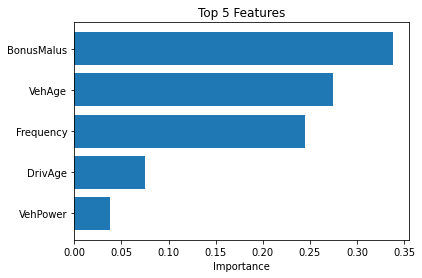

In [84]:
# Darstellung der feature importances als horizontaler Barplot
if len(feature_importances) > 0:
    # Sortieren der Feature Importances in absteigender Ordnung
    sorted_importances = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)
    
    # Top 5 Feature Importances
    top_features = sorted_importances[:5]
    top_names = [x[0] for x in top_features]
    top_importances = [x[1] for x in top_features]
    
    # Erzeugen eines horizontalen Barcharts
    fig, ax = plt.subplots()
    y_pos = range(len(top_names))
    ax.barh(y_pos, top_importances, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_names)
    ax.invert_yaxis()
    ax.set_xlabel('Importance')
    ax.set_title('Top 5 Features')
    plt.show()

## Anmerkungen
#### Verbesserungspotentiale
- Gruppieren einzelner Features in Gruppen (VehAge, DrivAge)
- GridSearch für die Hyperparameter-Optimierung verwenden
- Möglicher anderer Ansatz: beispielsweise erst Wahrscheinlichkeit für Schadensfall ermitteln und dann mit durchschnittlichem ClaimAmount multiplizieren
- Evtl. könnten weitere Variablen ausgeschlossen werden, da sie keine hohe Feature Importance besitzen

#### Probleme
- relativ kleine Anzahl an Schadensfällen: hohe Anzahl von Nullwerten im ClaimAmount kann zu Beeinträchtigung des Model fit führen, weil dies die geschätzten Werte Richtung Null ziehen kann
- möglicherweise sind einige Schadensfälle durch Einflüsse / Variablen / Faktoren entstanden, die im Datensatz nicht berücksichtigt sind
